In [1]:
import tensorflow as tf
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np

C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\frame

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True) 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
#np.random.seed(90) 
#tf.set_random_seed(90)

In [4]:
num_steps=100000 #No of times generator/discriminator is updated before it moves onto discriminator/generator?
learning_rate=0.0002
batch_size=128 #So that you don't have to load all your data at once
#Network Parameters
image_dim=784
gen_hnode_dim=1000
dis_hnode_dim=1000
noise_dim=100

#Initializing the weight parameters:
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

drop_out_rate=tf.placeholder(tf.float32)
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

In [5]:
#Defining in a way to avoid extra code

weights={'gen_ilayer':tf.Variable(glorot_init([noise_dim,gen_hnode_dim])),
         'gen_olayer':tf.Variable(glorot_init([gen_hnode_dim,image_dim])),
         'dis_ilayer':tf.Variable(glorot_init([image_dim,dis_hnode_dim])),
         'dis_olayer':tf.Variable(glorot_init([dis_hnode_dim,1]))}
biases={'gen_ilayer':tf.Variable(tf.zeros([gen_hnode_dim])),
         'gen_olayer':tf.Variable(tf.zeros([image_dim])),
         'dis_ilayer':tf.Variable(tf.zeros([dis_hnode_dim])),
         'dis_olayer':tf.Variable(tf.zeros([1]))}

In [6]:
def generator(data,dropout_rate):       
    l1=tf.add(tf.matmul(data,weights['gen_ilayer']),biases['gen_ilayer'])
    l1=tf.nn.relu(l1)
    #l1 = tf.layers.dropout(l1, dropout_rate)
    output=tf.add(tf.matmul(l1,weights['gen_olayer']),biases['gen_olayer'])
    output = tf.nn.sigmoid(output)
    return output
    

In [7]:
def discriminator(data,dropout_rate,seed):
    l1=tf.add(tf.matmul(data,weights['dis_ilayer']),biases['dis_ilayer'])
    l1=tf.nn.relu(l1)
    #l1 = tf.layers.dropout(l1, dropout_rate, seed=seed)
    output=tf.add(tf.matmul(l1,weights['dis_olayer']),biases['dis_olayer'])
    output = tf.nn.sigmoid(output)
    return output

In [8]:
gen_sample=generator(gen_input,drop_out_rate)

seed=np.random.randint(5,1000)
disc_real=discriminator(disc_input,drop_out_rate,seed)
disc_fake=discriminator(gen_sample,drop_out_rate,seed)

beta=0.01
eps=0.001
# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake+eps))
disc_loss = -tf.reduce_mean(tf.log(disc_real+eps) + tf.log(1. - disc_fake+eps))

regularizers_gen = tf.nn.l2_loss(weights['gen_olayer']) + tf.nn.l2_loss(weights['gen_ilayer'])
regularizers_dis = tf.nn.l2_loss(weights['dis_olayer']) + tf.nn.l2_loss(weights['dis_ilayer'])

gen_loss = tf.reduce_mean(gen_loss + beta * regularizers_gen)
disc_loss = tf.reduce_mean(disc_loss + beta * regularizers_dis)

#Building optimizer for generator and discriminator
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

generator_var=[weights['gen_ilayer'],weights['gen_olayer'],
               biases['gen_ilayer'],biases['gen_olayer']]

discriminator_var=[weights['dis_ilayer'],weights['dis_olayer'],
               biases['dis_ilayer'],biases['dis_olayer']]
train_gen=optimizer_gen.minimize(gen_loss,var_list=generator_var)
train_dis=optimizer_disc.minimize(disc_loss,var_list=discriminator_var)

init = tf.global_variables_initializer()

In [9]:
import matplotlib.gridspec as gridspec
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

Step 0: Generator Loss: 18.123589, Discriminator Loss: 12.245955


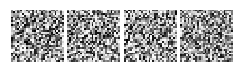

Step 1: Generator Loss: 18.371851, Discriminator Loss: 11.757360


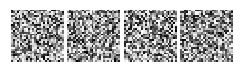

Step 4000: Generator Loss: 4.994658, Discriminator Loss: 0.523279


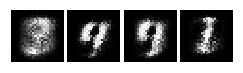

Step 8000: Generator Loss: 4.739401, Discriminator Loss: 0.687994


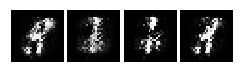

Step 12000: Generator Loss: 4.597854, Discriminator Loss: 0.654544


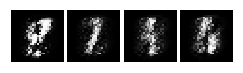

Step 16000: Generator Loss: 4.869315, Discriminator Loss: 0.530542


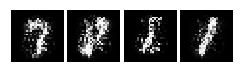

Step 20000: Generator Loss: 4.407180, Discriminator Loss: 0.604205


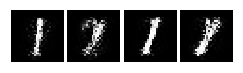

Step 24000: Generator Loss: 3.898877, Discriminator Loss: 0.608498


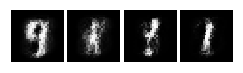

Step 28000: Generator Loss: 3.996503, Discriminator Loss: 0.508780


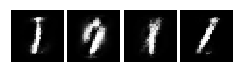

Step 32000: Generator Loss: 4.140976, Discriminator Loss: 0.487066


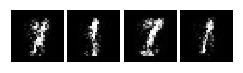

Step 36000: Generator Loss: 3.919768, Discriminator Loss: 0.522149


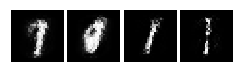

Step 40000: Generator Loss: 3.643864, Discriminator Loss: 0.593936


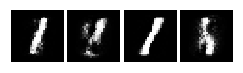

Step 44000: Generator Loss: 4.002557, Discriminator Loss: 0.569054


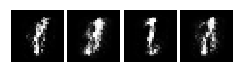

Step 48000: Generator Loss: 3.785151, Discriminator Loss: 0.515315


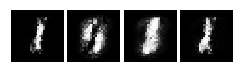

Step 52000: Generator Loss: 3.575588, Discriminator Loss: 0.556878


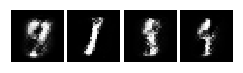

Step 56000: Generator Loss: 3.840024, Discriminator Loss: 0.442385


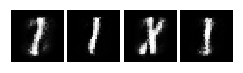

Step 60000: Generator Loss: 3.746725, Discriminator Loss: 0.567494


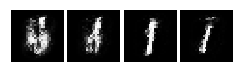

Step 64000: Generator Loss: 3.714937, Discriminator Loss: 0.522560


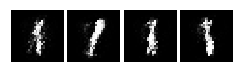

Step 68000: Generator Loss: 3.712782, Discriminator Loss: 0.493213


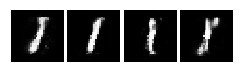

Step 72000: Generator Loss: 3.844455, Discriminator Loss: 0.510594


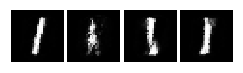

Step 76000: Generator Loss: 3.728436, Discriminator Loss: 0.587157


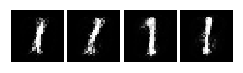

Step 80000: Generator Loss: 3.855526, Discriminator Loss: 0.557824


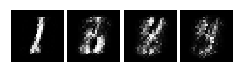

Step 84000: Generator Loss: 3.751744, Discriminator Loss: 0.521957


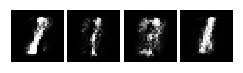

Step 88000: Generator Loss: 3.747120, Discriminator Loss: 0.561806


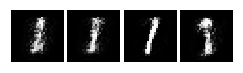

Step 92000: Generator Loss: 3.583508, Discriminator Loss: 0.610297


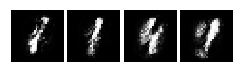

Step 96000: Generator Loss: 3.807674, Discriminator Loss: 0.569649


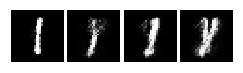

In [10]:
config = tf.ConfigProto(device_count = {'GPU': 1})
sess = tf.Session(config=config)

#with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
sess.run(init)
for i in range(num_steps):
    batch_x, _ = mnist.train.next_batch(batch_size)
    z = np.random.normal(0., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen,gen_loss], feed_dict={gen_input:z, drop_out_rate:0.9})
    _, dl = sess.run([train_dis,disc_loss],feed_dict={disc_input: batch_x, gen_input:z, drop_out_rate:0.9})
    if i % 4000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        z=np.random.normal(0, 1., size=[4, noise_dim])
        samples = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.9})
        fig = plot(samples)
        plt.show()

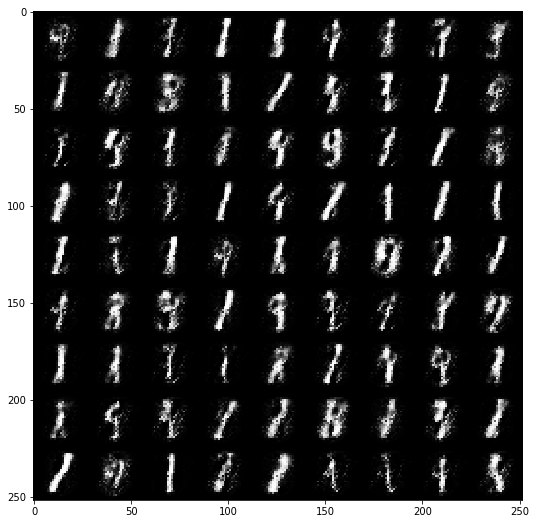

In [11]:
n = 9
averaging_over=10
arr=[]
canvas = np.empty((28 * n, 28 * n))
canvas1 = np.empty((averaging_over,28 * n, 28 * n))

for i in range(n):
    arr=[]
    z = np.random.normal(0., 1., size=[n, noise_dim])
    #print(z)
    g = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.9})
    #g = (g + 1.) / 2.
    for j in range(averaging_over):
        f = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.9})
        #f = (f + 1.) / 2.
        arr.append(f)
        g+= f
    g=g/11
    for j in range(n):
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28]) 

    for k in range(averaging_over):
        a=arr[k]
        for j in range(n):
            canvas1[k,i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = a[j].reshape([28, 28])    
            
plt.figure(figsize=(n, n))
plt.imshow(canvas1[7], origin="upper", cmap="gray")
plt.imsave('mnist_mcdropout_w1.png',canvas,cmap="gray")

for k in range(averaging_over):
    plt.imsave('mnist_mcdropout_{}.png'.format(k),canvas1[k],cmap="gray")

plt.show()